# Great Energy Predictor - Features

<a id='content3'></a>
## Content

1. [Data Description](#description3)
2. [Imports](#imports3)
3. [Data Preparation](#prep)
4. [Feature Elimination](#elim)
5. [Feature Selection](#seln)

<a id='description3'></a>
## 1. Data Description
[Back to top](#content3)

The data is a 2016 collection of energy meter readings (from over 1,000 buildings in 16 sites around the world) and weather measurements (from the nearest weather station for each site). It consists of 3 relational files of tabular data with the following features:
##### 1. train.csv - contains energy consumption measurements from 4 types of building meters in 2016
    - building_id - identifies the building
        - There are 1449 buildings in 16 sites around the world in this dataset
    - meter - meter type (not all buildings have all meter types)
        - 0 - electricity
        - 1 - chilldwater
        - 2 - steam
        - 3 - hotwater
    - timestamp - date and time of the meter reading
        - This dataset contains measurements over a span of an entire year
    - meter_reading - Energy consumption, (this is the target variable)
        - Electric meter readings are in kWh
            - Electric meter readings for site 0 are in kBTU
        - Chilled water meter readings are in tons
            - Chilled water meter readings for site 0 are in kBTU
        - Steam meter readings are in lbs
        - Hot water meter readings are in mmBTU
##### 2. weather_train.csv - contains weather measurements in 2016 from the weather station that is closest to the site
    - site_id - identifies the site where the building is
    - timestamp - date and time of the weather measurements
    - air_temperature - air temperature, in degrees Celsius
    - cloud_coverage - portion of the sky covered by clouds, in oktas
    - dew_temperature - temperature at which dew forms, in degrees Celsius
    - precip_depth_1_hr - measure of rainfail in 1 hour, in millimeters (mm)
    - sea_level_pressure - atmospheric pressure at sea level, in millibar (mbar) or hectopascals (hPa)
    - wind_direction - compass direction of the wind (0 - 360)
    - wind_speed - wind speed, in meters per second (m/s)
##### 3. building_metadata.csv - contains details about the buildings in the dataset
    - site_id - identifies the site where the building is
    - building_id - identifies the building
    - primary_use - what the building is used for (based on EnergyStar's property types)
    - square_feet - gross floor area of the building, in square feet (ft^2)
    - year_built - year the building was opened
    - floor_count - number of floors the building has
    
This data was retrieved from a public Kaggle competition hosted by ASHRAE.
##### Source: https://www.kaggle.com/c/ashrae-energy-prediction/data

<a id='imports3'></a>
## 2. Imports
[Back to top](#content3)

##### Import libraries

In [1]:
%matplotlib inline

import gc
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# import ray.dataframe as pd

In [2]:
# Default plot settings
sns.set(rc={'figure.figsize': (16, 6), 
            'font.size': 12})

##### Import data

In [3]:
data_path = '../data/output/'

In [4]:
dtypes = {
    'site_id': 'uint8',
    'building_id': 'uint16',
    'use_encoded': 'uint8',
    'primary_use': 'category',
    'year_built': 'uint16',
    'floor_count': 'uint8',
    'square_feet': 'uint32',
    'month': 'uint8',
    'day': 'uint8',
    'hour': 'uint8',
    'weekday': 'uint8',
    'meter': 'uint8',
    'type': 'category',
    'meter_reading': 'float32',
    'air_temperature': 'float32',
    'dew_temperature': 'float32',
    'sea_level_pressure': 'float32',
    'cloud_coverage': 'uint8',
    'precip_depth_1_hr': 'float32',
    'wind_direction': 'uint16',
    'wind_speed': 'float32'
}

In [5]:
df = pd.read_csv(f'{data_path}eda_train.csv', dtype=dtypes, parse_dates=['timestamp']).iloc[:, 1:]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20137746 entries, 0 to 20137745
Data columns (total 22 columns):
site_id               uint8
building_id           uint16
use_encoded           uint8
primary_use           category
year_built            uint16
floor_count           uint8
square_feet           uint32
timestamp             datetime64[ns]
month                 uint8
day                   uint8
hour                  uint8
weekday               uint8
meter                 uint8
type                  category
meter_reading         float32
air_temperature       float32
dew_temperature       float32
sea_level_pressure    float32
cloud_coverage        uint8
precip_depth_1_hr     float32
wind_direction        uint16
wind_speed            float32
dtypes: category(2), datetime64[ns](1), float32(6), uint16(3), uint32(1), uint8(9)
memory usage: 1017.9 MB


In [6]:
del dtypes
gc.collect()

42

<a id='prep'></a>
## 3. Data Preparation
[Back to top](#content3)

The `timestamp` column cannot be used in modeling so it will be removed and represented by other numeric columns. The 2 categorical columns `primary_use` and `type` also cannot be used in modeling so they will also be removed. These 2 columns have already been encoded into integers in separate columns. But since these categorical variables have no ordering to their values, it makes more sense to one-hot encode them.

##### Prepare the columns for feature selection

In [7]:
# Calculate day of the year
df['day_of_year'] = df.timestamp.astype('datetime64[D]') - pd.datetime(2015, 12, 31)
df.day_of_year = df.day_of_year.astype('timedelta64[D]').astype('uint16')

df.tail()

site_id  building_id  use_encoded                    primary_use  \
20137741       15         1444            1  Entertainment/public assembly   
20137742       15         1445            0                      Education   
20137743       15         1446            1  Entertainment/public assembly   
20137744       15         1447            4            Lodging/residential   
20137745       15         1448            6                         Office   

          year_built  floor_count  square_feet           timestamp  month  \
20137741        1914            1        19619 2016-12-31 23:00:00     12   
20137742        1964            1         4298 2016-12-31 23:00:00     12   
20137743        1997            1        11265 2016-12-31 23:00:00     12   
20137744        2001            1        29775 2016-12-31 23:00:00     12   
20137745        2001            3        92271 2016-12-31 23:00:00     12   

          day  ...         type  meter_reading  air_temperature  \
20137741   31  ...  electricity       8.750000              1.7   
20137742   31  ...  electricity       4.825000              1.7   
20137743   31  ...  electricity       0.000000              1.7   
20137744   31  ...  electricity     159.574997              1.7   
20137745   31  ...  electricity       2.850000              1.7   

         dew_temperature  sea_level_pressure  cloud_coverage  \
20137741            -5.6              1008.5               2   
20137742            -5.6              1008.5               2   
20137743            -5.6              1008.5               2   
20137744            -5.6              1008.5               2   
20137745            -5.6              1008.5               2   

          precip_depth_1_hr  wind_direction  wind_speed  day_of_year  
20137741               0.01             180         8.8          366  
20137742               0.01             180         8.8          366  
20137743               0.01             180         8.8          366  
20137744               0.01             180         8.8          366  
20137745               0.01             180         8.8          366  

[5 rows x 23 columns]

In [8]:
# One-hot encode primary_use
encoder1 = OneHotEncoder(sparse=False)
primary_use_ohe = encoder1.fit_transform(df[['primary_use']])

# Convert to dataframe
primary_use_ohe = pd.DataFrame(primary_use_ohe, columns=encoder1.categories_)
primary_use_ohe = primary_use_ohe.astype('uint8')
primary_use_ohe.head()

Education Entertainment/public assembly Food sales and service Healthcare  \
0         1                             0                      0          0   
1         1                             0                      0          0   
2         1                             0                      0          0   
3         1                             0                      0          0   
4         1                             0                      0          0   

  Lodging/residential Manufacturing/industrial Office Other Parking  \
0                   0                        0      0     0       0   
1                   0                        0      0     0       0   
2                   0                        0      0     0       0   
3                   0                        0      0     0       0   
4                   0                        0      0     0       0   

  Public services Religious worship Retail Services Technology/science  \
0               0                 0      0        0                  0   
1               0                 0      0        0                  0   
2               0                 0      0        0                  0   
3               0                 0      0        0                  0   
4               0                 0      0        0                  0   

  Utility Warehouse/storage  
0       0                 0  
1       0                 0  
2       0                 0  
3       0                 0  
4       0                 0

In [9]:
# One-hot encode meter type
encoder2 = OneHotEncoder(sparse=False)
meter_type_ohe = encoder2.fit_transform(df[['type']])

# Convert to dataframe
meter_type_ohe = pd.DataFrame(meter_type_ohe, columns=encoder2.categories_)
meter_type_ohe = meter_type_ohe.astype('uint8')
meter_type_ohe.head()

chilledwater electricity hotwater steam
0            0           1        0     0
1            0           1        0     0
2            0           1        0     0
3            0           1        0     0
4            0           1        0     0

In [10]:
# Combine the 2 encoded categories
cats_ohe = pd.concat([meter_type_ohe, primary_use_ohe], axis=1)
cats_ohe.head()

chilledwater electricity hotwater steam Education  \
0            0           1        0     0         1   
1            0           1        0     0         1   
2            0           1        0     0         1   
3            0           1        0     0         1   
4            0           1        0     0         1   

  Entertainment/public assembly Food sales and service Healthcare  \
0                             0                      0          0   
1                             0                      0          0   
2                             0                      0          0   
3                             0                      0          0   
4                             0                      0          0   

  Lodging/residential Manufacturing/industrial Office Other Parking  \
0                   0                        0      0     0       0   
1                   0                        0      0     0       0   
2                   0                        0      0     0       0   
3                   0                        0      0     0       0   
4                   0                        0      0     0       0   

  Public services Religious worship Retail Services Technology/science  \
0               0                 0      0        0                  0   
1               0                 0      0        0                  0   
2               0                 0      0        0                  0   
3               0                 0      0        0                  0   
4               0                 0      0        0                  0   

  Utility Warehouse/storage  
0       0                 0  
1       0                 0  
2       0                 0  
3       0                 0  
4       0                 0

In [11]:
# Drop non-numeric columns
df.drop(['timestamp', 'primary_use', 'type'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20137746 entries, 0 to 20137745
Data columns (total 20 columns):
site_id               uint8
building_id           uint16
use_encoded           uint8
year_built            uint16
floor_count           uint8
square_feet           uint32
month                 uint8
day                   uint8
hour                  uint8
weekday               uint8
meter                 uint8
meter_reading         float32
air_temperature       float32
dew_temperature       float32
sea_level_pressure    float32
cloud_coverage        uint8
precip_depth_1_hr     float32
wind_direction        uint16
wind_speed            float32
day_of_year           uint16
dtypes: float32(6), uint16(4), uint32(1), uint8(9)
memory usage: 864.2 MB


In [12]:
del encoder1, encoder2, primary_use_ohe, meter_type_ohe

##### Separate the target variable and split the dataset into a train and test set

In [13]:
# Variables and target
X = df.drop('meter_reading', axis=1)
y = df.meter_reading

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Train-test split for one-hot encoded categorical variables
cat_train, cat_test, lab_train, lab_test = train_test_split(cats_ohe, y, test_size=0.2, random_state=42)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (16110196, 19)
X_test: (4027550, 19)
y_train: (16110196,)
y_test: (4027550,)


In [14]:
del df, cats_ohe, lab_train, lab_test
gc.collect()

88

Now the data is ready for feature selection. The one-hot encoded categorical variables are kept separate to avoid cluttering the training data. 

<a id='elim'></a>
## 4. Feature Elimination
[Back to top](#content3)

##### Constant and quasi-constant features

In [15]:
# Main data
const = pd.DataFrame(X_train.var(), columns=['variance'])
const['constant'] = const.variance == 0
const['quasiconstant'] = const.variance < 0.01
const

variance  constant  quasiconstant
site_id             2.589821e+01     False          False
building_id         1.812953e+05     False          False
use_encoded         1.187137e+01     False          False
year_built          3.844191e+02     False          False
floor_count         1.256733e+01     False          False
square_feet         1.375616e+10     False          False
month               1.181234e+01     False          False
day                 7.779519e+01     False          False
hour                4.792584e+01     False          False
weekday             3.988601e+00     False          False
meter               8.688400e-01     False          False
air_temperature     1.204038e+02     False          False
dew_temperature     1.037428e+02     False          False
sea_level_pressure  5.247845e+01     False          False
cloud_coverage      7.361325e+00     False          False
precip_depth_1_hr   8.025482e+01     False          False
wind_direction      1.126765e+04     False          False
wind_speed          5.128145e+00     False          False
day_of_year         1.108220e+04     False          False

In [16]:
# Primary use categories
const_cat = pd.DataFrame(cat_train.var(), columns=['variance'])
const_cat['quasiconstant'] = const_cat.variance < 0.01
const_cat

variance  quasiconstant
chilledwater                   0.164187          False
electricity                    0.240858          False
hotwater                       0.058870          False
steam                          0.116416          False
Education                      0.240752          False
Entertainment/public assembly  0.099653          False
Food sales and service         0.005625           True
Healthcare                     0.019373          False
Lodging/residential            0.095270          False
Manufacturing/industrial       0.006203           True
Office                         0.169957          False
Other                          0.011895          False
Parking                        0.010521          False
Public services                0.075723          False
Religious worship              0.001606           True
Retail                         0.004703           True
Services                       0.004771           True
Technology/science             0.003845           True
Utility                        0.002781           True
Warehouse/storage              0.005508           True

In [17]:
# Quasi-constant
qc_cats = [cat[0] for cat in const_cat[const_cat.quasiconstant].index]
qc_cats

['Food sales and service',
 'Manufacturing/industrial',
 'Religious worship',
 'Retail',
 'Services',
 'Technology/science',
 'Utility',
 'Warehouse/storage']

Exactly half of the `primary_use` categories were found to be quasi-constant. As per the variance threshold of 0.01, being quasi-constant means that each of these 8 building types individually make up less than 1% of the total data. For now these will be kept as they are not part of the main data. Aside from this, there are no constant and no other quasi-constant features.

##### Duplicate features

In [18]:
# # Check if columns are pairwise equal
# dups = [] 
# for i, col1 in enumerate(X_train.columns[:-1]):
#     for col2 in X_train.columns[i+1:]:
#         if X_train[col1].equals(X_train[col2]):
#             dups.append((col1, col2))
# dups

##### Correlated features

In [19]:
pearson = X_train.corr()
pearson

site_id  building_id  use_encoded  year_built  \
site_id             1.000000     0.980861     0.080181   -0.095307   
building_id         0.980861     1.000000     0.061838   -0.135724   
use_encoded         0.080181     0.061838     1.000000    0.065391   
year_built         -0.095307    -0.135724     0.065391    1.000000   
floor_count         0.017487     0.013682    -0.087734    0.080458   
square_feet         0.087738     0.084269    -0.085659    0.098957   
month               0.015041     0.015079    -0.002221   -0.000175   
day                -0.000436    -0.000314     0.000117    0.000052   
hour               -0.000097    -0.000056    -0.000179    0.000179   
weekday            -0.000051    -0.000052    -0.000277   -0.000135   
meter               0.252366     0.220563    -0.081101    0.011316   
air_temperature    -0.306558    -0.313527    -0.044185    0.089907   
dew_temperature    -0.132264    -0.107007    -0.015018    0.033799   
sea_level_pressure  0.051948     0.072042     0.030871   -0.023799   
cloud_coverage     -0.125185    -0.159972     0.143474    0.053754   
precip_depth_1_hr   0.052284     0.055784    -0.022479   -0.014072   
wind_direction      0.067460     0.077153    -0.013603   -0.020954   
wind_speed          0.012111     0.004139     0.052509   -0.019765   
day_of_year         0.014951     0.014999    -0.002198   -0.000187   

                    floor_count  square_feet     month       day      hour  \
site_id                0.017487     0.087738  0.015041 -0.000436 -0.000097   
building_id            0.013682     0.084269  0.015079 -0.000314 -0.000056   
use_encoded           -0.087734    -0.085659 -0.002221  0.000117 -0.000179   
year_built             0.080458     0.098957 -0.000175  0.000052  0.000179   
floor_count            1.000000     0.901321 -0.003100 -0.000344  0.000018   
square_feet            0.901321     1.000000 -0.002578 -0.000280  0.000101   
month                 -0.003100    -0.002578  1.000000  0.011939 -0.000005   
day                   -0.000344    -0.000280  0.011939  1.000000  0.000307   
hour                   0.000018     0.000101 -0.000005  0.000307  1.000000   
weekday                0.000057    -0.000024 -0.002541  0.003439 -0.000029   
meter                  0.099968     0.131747  0.005562 -0.000110  0.000140   
air_temperature       -0.024525    -0.015081  0.168821  0.024450  0.141878   
dew_temperature       -0.011089    -0.022291  0.241758  0.024994 -0.006360   
sea_level_pressure    -0.015905    -0.018702  0.123289  0.010445 -0.032270   
cloud_coverage        -0.044064    -0.012970 -0.020518  0.014201  0.024394   
precip_depth_1_hr      0.024381     0.038838  0.018231  0.000857  0.006380   
wind_direction         0.005642     0.006305  0.004477 -0.012332 -0.016472   
wind_speed            -0.018905    -0.034542 -0.068893 -0.009472  0.122709   
day_of_year           -0.003112    -0.002587  0.996487  0.095537  0.000019   

                     weekday     meter  air_temperature  dew_temperature  \
site_id            -0.000051  0.252366        -0.306558        -0.132264   
building_id        -0.000052  0.220563        -0.313527        -0.107007   
use_encoded        -0.000277 -0.081101        -0.044185        -0.015018   
year_built         -0.000135  0.011316         0.089907         0.033799   
floor_count         0.000057  0.099968        -0.024525        -0.011089   
square_feet        -0.000024  0.131747        -0.015081        -0.022291   
month              -0.002541  0.005562         0.168821         0.241758   
day                 0.003439 -0.000110         0.024450         0.024994   
hour               -0.000029  0.000140         0.141878        -0.006360   
weekday             1.000000  0.000082        -0.006489        -0.005497   
meter               0.000082  1.000000        -0.010970        -0.079513   
air_temperature    -0.006489 -0.010970         1.000000         0.751499   
dew_temperature    -0.005497 -0.079513         0.751499         1.00000

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 <a list of 19 Text xticklabel objects>)

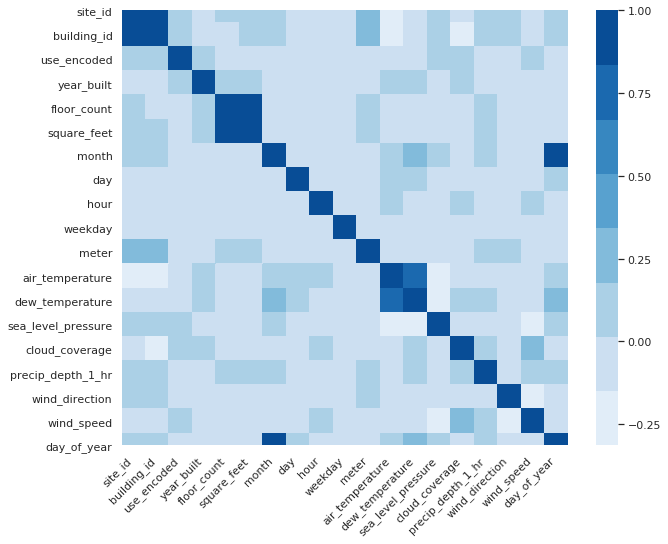

In [20]:
fig = plt.figure(figsize=(10, 8))
sns.heatmap(pearson, cmap=sns.color_palette('Blues', 8))
plt.xticks(rotation=45, ha='right')

In [21]:
# Correlation threshold = 0.7
corr = []
for i, feat1 in enumerate(pearson.columns[:-1]):
    for feat2 in pearson.columns[i+1:]:
        p = pearson.loc[feat1, feat2]
        if p > 0.7:
            corr.append([feat1, feat2, p])
corr

[['site_id', 'building_id', 0.9808612793455758],
 ['floor_count', 'square_feet', 0.9013205573669524],
 ['month', 'day_of_year', 0.9964867635352562],
 ['air_temperature', 'dew_temperature', 0.7514988326447333]]

There are 4 pairs of highly correlated features in the data:
- `site_id` and `building_id` - both of these features are actually non-cardinal categorical variables encoded as integers, so the correlation coefficient isn't reliable here
    - There is some relationship between `site_id` and `building_id` but the ordered integer encoding makes the relationship appear stronger than it actually is
    - These 2 variables are providing different information
    - Since `site_id` can be inferred from building and weather information, it wouldn't be necessary to keep it so `site_id` will be removed
- `floor_count` and `square_feet` - the majority of `floor_count` values were originally missing and filled based on the `square_feet` in a linear manner so this high correlation isn't completely reliable either
    - Before the missing values were filled, there were a lot of outliers that prevented it from being a strong correlation
    - Since they were filled in such a way that increased the correlation, only 1 is really needed here
    - `floor_count` will be removed because `square_feet` is a more accurate description of a building's size
- `month` and `day_of_year` - both of these features were extracted from the `timestamp` along the timeline of the year so it makes sense that there is a strong correlation
    - These 2 features actually do provide similar information so it would be redundant to keep both
    - `month` will be dropped as `day_of_year` is more fine-grained and may provide more information
- `air_temperature` and `dew_temperature` - as seen in the visualizations during the EDA process, these 2 features do track each other quite closely so only 1 is necessary
    - `dew_temperature` will be dropped as `air_temperature` is a more concrete measure of the weather
    
##### Create a list of columns to drop and add the `site_id`, `floor_count`, `month`, and `dew_temperature` columns

In [22]:
cols_to_drop = ['site_id', 'floor_count', 'month', 'dew_temperature']

In [23]:
del const, const_cat, pearson, corr, feat1, feat2, i, p, fig # , dups, col1, col2, 
gc.collect()

NameError: name 'col1' is not defined

<a id='seln'></a>
## 5. Feature Selection
[Back to top](#content3)

In [24]:
X_train.drop(cols_to_drop, axis=1, inplace=True)
X_test.drop(cols_to_drop, axis=1, inplace=True)

/home/tri/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
X_train.head()

building_id  use_encoded  year_built  square_feet  day  hour  \
11802573         1098            6        1970       131745    4    17   
14525952          494            0        1959        72800   22    15   
7175581           932            4        1968       233937   14     1   
5040632          1220            9        1961       381221    5    22   
2485779           908            0        1964        91254   15    17   

          weekday  meter  air_temperature  sea_level_pressure  cloud_coverage  \
11802573        3      2        27.799999         1008.200012               2   
14525952        3      0        30.000000         1018.400024               4   
7175581         5      2        23.900000         1017.299988               0   
5040632         1      2         2.800000         1008.299988               8   
2485779         0      0        22.799999         1011.400024               0   

          precip_depth_1_hr  wind_direction  wind_speed  day_of_year  
11802573                0.0             310         8.2          217  
14525952                0.0              60         4.6          266  
7175581                 0.0             360         0.0          135  
5040632                 0.0             130         5.1           96  
2485779                 0.0             360         3.6           46

In [103]:
Xtrn, Xtst, ytrn, ytst = train_test_split(X_train, y_train, train_size=0.1, random_state=42)
print(Xtrn.shape)
print(Xtst.shape)
print(ytrn.shape)
print(ytst.shape)

(1611019, 19)
(14499177, 19)
(1611019,)
(14499177,)


# 1

In [106]:
print(datetime.datetime.now())

rf = RandomForestRegressor(n_estimators=32, random_state=0)
params = {'max_depth': [4, 8, 16, 32, 64, 128], 
          'min_samples_split': [50, 100, 300, 500, 700, 900]}

search = GridSearchCV(rf, params, cv=4, n_jobs=8, verbose=3)
search.fit(Xtrn, ytrn)

print('Best score:', search.best_score_)
print('Best parameters:', search.best_params_)

print(datetime.datetime.now())

2019-12-13 18:28:31.265695
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  5.9min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed: 91.0min
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed: 124.3min finished


Best score: 0.8787698329329584
Best parameters: {'max_depth': 16, 'min_samples_split': 50}
2019-12-13 20:38:00.553660


In [109]:
y_pred = search.best_estimator_.predict(Xtst)

In [111]:
rmse = np.sqrt(mean_squared_error(ytst, y_pred))
rmse

55881.16621007994

In [113]:
rmsle = np.sqrt(mean_squared_log_error(ytst, y_pred))
rmsle

1.3068439323584704

# 2

In [114]:
print(datetime.datetime.now())

rf = RandomForestRegressor(n_estimators=32, random_state=0)
params = {'max_depth': [10, 15, 20, 25], 
          'min_samples_split': [20, 40, 60, 80]}

search2 = GridSearchCV(rf, params, cv=4, n_jobs=8, verbose=3)
search2.fit(Xtrn, ytrn)

print('Best score:', search2.best_score_)
print('Best parameters:', search2.best_params_)

print(datetime.datetime.now())

2019-12-13 20:51:07.774547
Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/home/tri/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed: 12.7min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed: 62.7min finished


Best score: 0.8807152693357829
Best parameters: {'max_depth': 15, 'min_samples_split': 40}
2019-12-13 21:58:47.583181


In [115]:
y_pred2 = search2.best_estimator_.predict(Xtst)

In [116]:
rmse2 = np.sqrt(mean_squared_error(ytst, y_pred2))
rmse2

55346.7620838393

In [117]:
rmsle2 = np.sqrt(mean_squared_log_error(ytst, y_pred2))
rmsle2

1.383095357306407

# 3

In [118]:
print(datetime.datetime.now())

rf = RandomForestRegressor(n_estimators=32, max_depth=16, min_samples_split=50, random_state=0)
params = {'min_samples_leaf': range(5, 45, 5)}

search3 = GridSearchCV(rf, params, cv=4, n_jobs=8, verbose=3)
search3.fit(Xtrn, ytrn)

print('Best score:', search3.best_score_)
print('Best parameters:', search3.best_params_)

print(datetime.datetime.now())

2019-12-13 21:59:45.363255
Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/home/tri/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed: 16.1min
[Parallel(n_jobs=8)]: Done  28 out of  32 | elapsed: 31.9min remaining:  4.6min
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed: 32.0min finished


Best score: 0.8793346013608176
Best parameters: {'min_samples_leaf': 5}
2019-12-13 22:36:56.660781


In [119]:
y_pred3 = search3.best_estimator_.predict(Xtst)

In [120]:
rmse3 = np.sqrt(mean_squared_error(ytst, y_pred3))
rmse3

56108.77149025306

In [121]:
rmsle3 = np.sqrt(mean_squared_log_error(ytst, y_pred3))
rmsle3

1.3061306801257593

# 4

In [122]:
print(datetime.datetime.now())

rf = RandomForestRegressor(n_estimators=32, max_depth=15, min_samples_split=40, random_state=0)
params = {'min_samples_leaf': range(2, 25, 2)}

search4 = GridSearchCV(rf, params, cv=4, n_jobs=8, verbose=3)
search4.fit(Xtrn, ytrn)

print('Best score:', search4.best_score_)
print('Best parameters:', search4.best_params_)

print(datetime.datetime.now())

2019-12-14 09:20:32.324892
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/home/tri/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed: 15.8min
[Parallel(n_jobs=8)]: Done  48 out of  48 | elapsed: 46.8min finished


Best score: 0.880427475091644
Best parameters: {'min_samples_leaf': 4}
2019-12-14 10:12:19.704393


In [123]:
y_pred4 = search4.best_estimator_.predict(Xtst)

In [124]:
rmse4 = np.sqrt(mean_squared_error(ytst, y_pred4))
rmse4

55529.715738555846

In [125]:
rmsle4 = np.sqrt(mean_squared_log_error(ytst, y_pred4))
rmsle4

1.3827217681208048

# Full 1

In [29]:
print(datetime.datetime.now())

rf = RandomForestRegressor(n_estimators=32, random_state=0)
params = {'max_depth': [15, 50],
          'min_samples_split': [40, 100]}

full = GridSearchCV(rf, params, cv=4, n_jobs=8, verbose=3)
full.fit(X_train, y_train)

print('Best score:', full.best_score_)
print('Best parameters:', full.best_params_)

print(datetime.datetime.now())

2019-12-15 08:39:21.614366
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  16 | elapsed: 109.9min remaining: 141.4min
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed: 249.6min remaining: 57.6min
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed: 250.0min finished


Best score: 0.9361698619606519
Best parameters: {'max_depth': 50, 'min_samples_split': 40}
2019-12-15 14:29:12.272096


In [30]:
y_preds = full.best_estimator_.predict(X_test)

In [31]:
r = np.sqrt(mean_squared_error(y_test, y_preds))
r

34321.46061311407

In [32]:
l = np.sqrt(mean_squared_log_error(y_test, y_preds))
l

0.6787057231010526

# Full 2

In [30]:
print(datetime.datetime.now())

rf = RandomForestRegressor(n_estimators=32, min_samples_split=40, random_state=0)
params = {'max_depth': [60, 80]}

full2 = GridSearchCV(rf, params, cv=4, n_jobs=8, verbose=3)
full2.fit(X_train, y_train)

print('Best score:', full2.best_score_)
print('Best parameters:', full2.best_params_)

print(datetime.datetime.now())

2019-12-16 16:30:45.473657
Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed: 118.1min remaining: 354.2min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed: 118.2min remaining: 70.9min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 118.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 118.7min finished


Best score: 0.9381143916042173
Best parameters: {'max_depth': 80}
2019-12-16 19:49:56.667516


In [31]:
y_preds2 = full2.best_estimator_.predict(X_test)

In [32]:
r2 = np.sqrt(mean_squared_error(y_test, y_preds2))
r2

34537.516408393814

In [33]:
l2 = np.sqrt(mean_squared_log_error(y_test, y_preds2))
l2

0.6735756462180386

# Full 3

In [ ]:
print(datetime.datetime.now())

rf = RandomForestRegressor(n_estimators=32, max_depth=80, random_state=0)
params = {'min_samples_split': [20, 40, 60], 
          'min_samples_leaf': [5, 10]}

full3 = GridSearchCV(rf, params, cv=4, n_jobs=8, verbose=3)
full3.fit(X_train, y_train)

print('Best score:', full3.best_score_)
print('Best parameters:', full3.best_params_)

print(datetime.datetime.now())

2019-12-16 19:58:14.033605
Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
y_preds3 = full3.best_estimator_.predict(X_test)

In [ ]:
r3 = np.sqrt(mean_squared_error(y_test, y_preds3))
r3

In [ ]:
l3 = np.sqrt(mean_squared_log_error(y_test, y_preds3))
l3

# Full 4

In [ ]:
print(datetime.datetime.now())

rf = RandomForestRegressor(n_estimators=32, max_depth=80, min_samples_split=40, random_state=0)
params = {'min_samples_split': [20, 40, 60], 
          'min_samples_leaf': [5, 10]}

full4 = GridSearchCV(rf, params, cv=4, n_jobs=8, verbose=3)
full4.fit(X_train, y_train)

print('Best score:', full4.best_score_)
print('Best parameters:', full4.best_params_)

print(datetime.datetime.now())

2019-12-16 19:57:26.804704
Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
y_preds4 = full4.best_estimator_.predict(X_test)

In [ ]:
r4 = np.sqrt(mean_squared_error(y_test, y_preds4))
r4

In [ ]:
l4 = np.sqrt(mean_squared_log_error(y_test, y_preds4))
l4

In [82]:
rf = RandomForestRegressor(n_estimators=80, max_depth=8, min_samples_split=40, min_samples_leaf=16, random_state=0, n_jobs=16, verbose=3)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 80building tree 2 of 80
building tree 3 of 80
building tree 4 of 80
building tree 5 of 80
building tree 6 of 80
building tree 7 of 80
building tree 8 of 80
building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80

building tree 17 of 80
building tree 18 of 80
building tree 19 of 80building tree 20 of 80
building tree 21 of 80

building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80building tree 28 of 80

building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80
building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 

[Parallel(n_jobs=16)]: Done  76 out of  80 | elapsed: 30.9min remaining:  1.6min
[Parallel(n_jobs=16)]: Done  80 out of  80 | elapsed: 31.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  76 out of  80 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  80 out of  80 | elapsed:    2.0s finished


0.9184812627928041

In [83]:
rmse = np.sqrt(mean_squared_error(y_test, rf.predict(X_test)))
rmse

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  76 out of  80 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  80 out of  80 | elapsed:    1.6s finished


45918.01314773768

In [84]:
rmlse = np.sqrt(mean_squared_log_error(y_test, rf.predict(X_test)))
rmlse

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  76 out of  80 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  80 out of  80 | elapsed:    1.7s finished


2.0377294567569284